In [1]:
import pandas as pd
import numpy as np
import keras
from tqdm import tqdm_notebook
from progress.bar import Bar
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from glob import glob
import os,cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [18]:
train_csv = pd.read_csv('train.csv')

In [19]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [2]:
train_path = 'train_images/'
test_path = 'test_images/'

(2136, 3216)


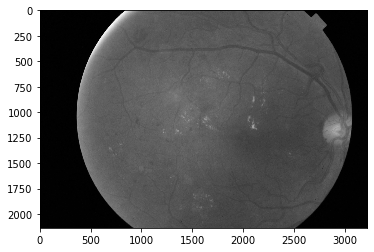

In [5]:
for i in range(len(train_csv)):
    img = cv2.imread(train_path + train_csv['id_code'][i]+'.png',0)
    print(img.shape)
    plt.imshow(img,cmap = 'gray')
    break

(2136, 3216)


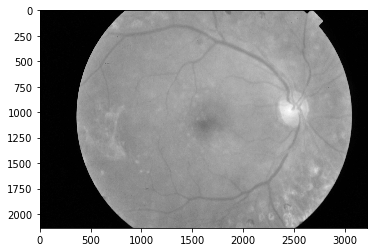

In [6]:
img = cv2.imread(train_path + '001639a390f0'+'.png',0)
print(img.shape)
plt.imshow(img,cmap = 'gray')

(1736, 2416)


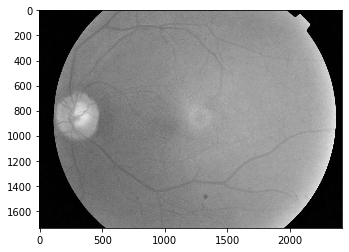

In [7]:
img = cv2.imread(train_path + '0024cdab0c1e'+'.png',0)
print(img.shape)
plt.imshow(img,cmap = 'gray')

(1050, 1050)


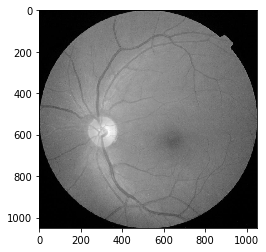

In [8]:
img = cv2.imread(train_path + '002c21358ce6'+'.png',0)
print(img.shape)
plt.imshow(img,cmap = 'gray')

(1536, 2048)


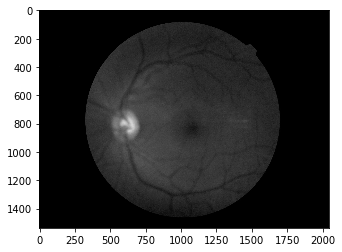

In [9]:
img = cv2.imread(train_path + '005b95c28852'+'.png',0)
print(img.shape)
plt.imshow(img,cmap = 'gray')

In [10]:
train_csv['diagnosis'].unique()

array([2, 4, 1, 0, 3])

In [21]:
print("Total number of images in No DR class: ",len(train_csv[train_csv['diagnosis'] == 0]))
print("Total number of images in Mild class: ",len(train_csv[train_csv['diagnosis'] == 1]))
print("Total number of images in Moderate class: ",len(train_csv[train_csv['diagnosis'] == 2]))
print("Total number of images in Severe class: ",len(train_csv[train_csv['diagnosis'] == 3]))
print("Total number of images in Proliferative DR class: ",len(train_csv[train_csv['diagnosis'] == 4]))
print("Total number of train images: ",len(train_csv))

Total number of images in No DR class:  1805
Total number of images in Mild class:  370
Total number of images in Moderate class:  999
Total number of images in Severe class:  193
Total number of images in Proliferative DR class:  295
Total number of train images:  3662


In [22]:
def plot_bar_x(label,no_images):
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_images)
    plt.xlabel('Image_type', fontsize=10)
    plt.ylabel('No of Images', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=0)
    plt.title('Data Visualization')
    plt.show()


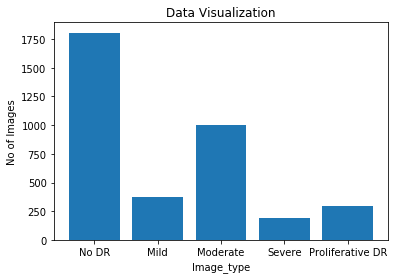

In [23]:
label = ['No DR','Mild','Moderate','Severe','Proliferative DR']
no_images=[len(train_csv[train_csv['diagnosis'] == 0]),len(train_csv[train_csv['diagnosis'] == 1]),
           len(train_csv[train_csv['diagnosis'] == 2]),len(train_csv[train_csv['diagnosis'] == 3]),
          len(train_csv[train_csv['diagnosis'] == 4])]
plot_bar_x(label,no_images)

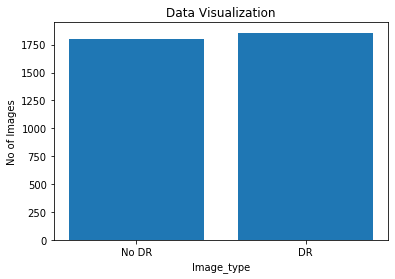

In [24]:
label = ['No DR','DR']
no_images=[len(train_csv[train_csv['diagnosis'] == 0]),len(train_csv[train_csv['diagnosis'] == 1])+
           len(train_csv[train_csv['diagnosis'] == 2])+len(train_csv[train_csv['diagnosis'] == 3])+
          len(train_csv[train_csv['diagnosis'] == 4])]
plot_bar_x(label,no_images)

In [25]:
def get_data(img_path,image_csv):
    X = []
    Y = []
    images_list = os.listdir(img_path)
    bar = Bar('Processing',max = len(images_list))
    for i in tqdm_notebook(range(len(images_list))):
        img = cv2.imread(img_path + image_csv['id_code'][i] + '.png')
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),256/30),-4,128)
        X.append(cv2.resize(img,(256,256)))
        Y.append(image_csv['diagnosis'][i])
        bar.next()
        
    return np.array(X),np.array(Y)
    bar.finish()
        

In [ ]:
train_X,train_Y = get_data(train_path,train_csv)

In [ ]:
train_X = train_X/255

### model

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout,Dense,Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint,CSVLogger,ReduceLROnPlateau
from keras.optimizers import Adam,RMSprop
from keras.utils import to_categorical

In [ ]:
def pretrained_model(model,img_shape,trainable = False,weights = None,optim='adam',lr = 0.001,weighted_metrics = None):
    if model == 'densenet121':
        base_model = DenseNet121(include_top=False,weights= weights,input_shape = img_shape)
    elif model == 'inception':
        base_model = InceptionV3(include_top=False,weights= weights,input_shape = img_shape)
    elif model == 'mobilenet':
        base_model = MobileNet(include_top=False,weights= weights,input_shape = img_shape)
    elif model == 'vgg':
        base_model = VGG19(include_top=False,weights= weights,input_shape = img_shape)
    elif model == 'resnet50':
        base_model = ResNet50V2(include_top=False,weights= weights,input_shape = img_shape)
    elif model =='resnet101':
        base_model = ResNet101V2(include_top = False,weights = weights,input_shape = img_shape)
    elif model == 'xception':
        base_model = Xception(include_top=False,weights= weights,input_shape = img_shape)
        
    for layer in base_model.layers:
        layer.trainable = trainable
        
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(2048,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(512,activation = 'relu')(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(5,activation='softmax')(x)
    
    model = Model(base_model.input,predictions)
    print(model.summary())

    if optim == 'adam':
        model.compile(optimizer=Adam(lr),loss = 'categorical_crossentropy',
                      metrics=['accuracy'],weighted_metrics=weighted_metrics)
    elif optim == 'rms':
        model.compile(optimizer=RMSprop(lr),loss = 'categorical_crossentropy',
                      metrics=['accuracy'],weighted_metrics= weighted_metrics)
    return model

In [ ]:
model = pretrained_model('mobilenet',(256,256,3))

In [ ]:
# csv_logger = CSVLogger("result/csv/vgg_tr_1.csv",separator = ",",append=True)
# checkpoint = ModelCheckpoint('result/model/vgg_tr_1.h5',monitor='val_acc',
#                          verbose=1,
#                         save_best_only= True)

# learning_rate = ReduceLROnPlateau(monitor='val_acc',
#                              factor = 0.1,
#                              patience = 2,
#                              verbose = 1)
# callback = [checkpoint,learning_rate,csv_logger]

In [ ]:
train_X,X_va,train_Y,Y_va = train_test_split(train_X,train_Y,
                                       test_size = 0.10,stratify = train_Y)

In [ ]:
train_Y = to_categorical(train_Y,num_classes=5)
Y_va = to_categorical(Y_va,num_classes=5)

In [ ]:
print('train_X shape: ',train_X.shape)
print('train_Y shape: ',train_Y.shape)
print('X_valid shape: ',X_va.shape)
print('Y_valid shape: ',Y_va.shape)

In [ ]:
model.fit(train_X,train_Y,batch_size=64,epochs=50,verbose=1,validation_data=(X_va,Y_va))

## prediction

In [3]:
def get_data(img_path,image_csv):
    X = []
    Y = []
    images_list = os.listdir(img_path)
    bar = Bar('Processing',max = len(images_list))
    for i in tqdm_notebook(range(len(images_list))):
        img = cv2.imread(img_path + image_csv['id_code'][i] + '.png')
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#         img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),256/30),-4,128)
        X.append(cv2.resize(img,(256,256)))
        
        bar.next()
        
    return np.array(X)
    bar.finish()
        

In [4]:
sample_sub = pd.read_csv('sample_submission.csv')

In [5]:
X_test = get_data(test_path,sample_sub)

In [6]:
X_test.shape

(1928, 256, 256, 3)

In [7]:
from keras.models import load_model

In [8]:
model = load_model('result/model/dense_tr_binary_2.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [ ]:
y_pred = model.predict(X_test,verbose=1)
y_pred = np.argmax(y_pred,axis = 1)
print(y_pred.shape)

1728/1928 [=========================>....] - ETA: 1s

In [11]:
(y_pred == 0).sum()

1928